In [25]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import pingouin as pg
import scienceplots
import seaborn as sns

from plot import annotate_plot, clear_axes, set_size

os.makedirs("img", exist_ok=True)

plt.style.use(["science", "nature"])
plt.rcParams["font.size"] = 10
plt.rcParams["legend.title_fontsize"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

PALETTE = dict(zip(["E. coli", "Control"], sns.color_palette("colorblind").as_hex()))

# Physiological analysis

In [3]:
file = "data/physio/physiological_data.xlsx"

boxes = {1: "Control", 4: "E. coli"}

def try_float(x):
    try:
        return float(x)
    except ValueError:
        return float("nan")

## SAA

### Data

In [4]:
prot = pd.read_excel(file, sheet_name="Acute phase protein")

prot.columns = [
    "SID",
    "OrderDate",
    "TestName",
    "Units",
    "ResultString",
    "Column1",
    "Column2",
    "7",
    "Box",
]

prot.drop(["7", "Column1", "Column2"], axis=1, inplace=True)

prot.Box.ffill(inplace=True)

prot.ResultString = prot.ResultString.replace("< 0.0", 1e-8).astype(float)

prot.Box = prot.Box.apply(lambda x: boxes[int(x.split("BOX ")[1])])

prot.sort_values(by="Box", inplace=True)

prot.dropna(inplace=True)

prot.head()

,SID,OrderDate,TestName,Units,ResultString,Box
17,2023-17-019,8/9/2023 1:24 PM,XSAA,mg/L,1.000000e-08,Control
19,2023-17-016,8/9/2023 1:24 PM,XSAA,mg/L,1.000000e-08,Control
20,2023-17-015,8/9/2023 1:24 PM,XSAA,mg/L,1.000000e-08,Control
21,2023-17-014,8/9/2023 1:24 PM,XSAA,mg/L,1.000000e-08,Control
22,2023-17-013,8/9/2023 1:24 PM,XSAA,mg/L,1.000000e-08,Control


### Statistical analysis

#### QQ-plot

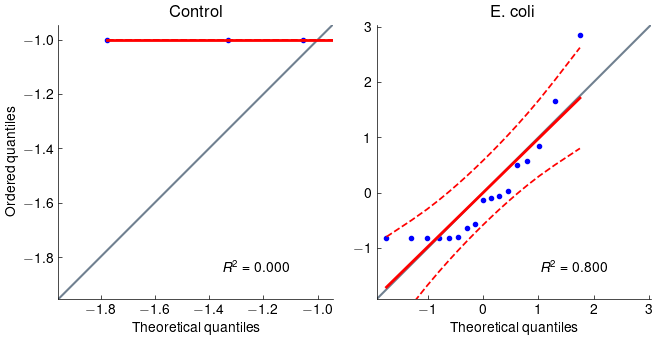

In [5]:
boxes_ = set(prot.Box)

fig, axs = plt.subplots(1, len(boxes_), figsize=set_size(490, "s"))

for i, box in enumerate(boxes_):
    try:
        pg.qqplot(x=prot.query("Box == @box").ResultString, ax=axs[i])
        axs[i].set_title(box.replace("\n", " "))

        if i > 0:
            axs[i].set_ylabel("")
    except ValueError:
        axs[i].remove()
        continue

fig.tight_layout()
clear_axes()
plt.show()

#### Levene's test

In [6]:
pg.homoscedasticity(data=prot.dropna(), dv="ResultString", group="Box")

,W,pval,equal_var
levene,18.723461,0.000132,False


#### ANOVA (Kruskal-Wallis)

In [7]:
aov = pg.kruskal(data=prot, dv="ResultString", between="Box", detailed=True)

aov

,Source,ddof1,H,p-unc
Kruskal,Box,1,17.732604,0.000025


#### Pairwise non-parametric tests

In [8]:
stats = pg.pairwise_tests(
    data=prot,
    dv="ResultString",
    between="Box",
    effsize="cohen",
    parametric=False,
)

stats

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,cohen
0,Box,Control,E. coli,False,False,45.0,two-sided,0.000028,-1.152561


### Plot

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Control vs. E. coli: Custom statistical test, P_val:2.771e-05


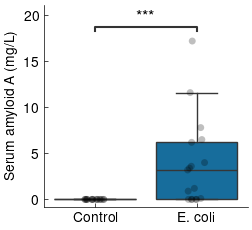

In [10]:
fig, ax = plt.subplots(figsize=set_size(190, "s"))

plot_params = dict(x="Box", y="ResultString", data=prot)

sns.boxplot(**plot_params, palette=PALETTE, showfliers=False)
sns.stripplot(**plot_params, color="k", alpha=0.25)

annotate_plot(ax, plot_params, stats["p-unc"])

plt.ylabel("Serum amyloid A (mg/L)")
plt.xlabel("")
clear_axes()
plt.savefig("img/saa.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

## Lesions

### Data

In [11]:
les = pd.read_excel(file, sheet_name="Lesion scores", header=[0, 1, 2])

les.drop(les.columns[[1, 2, -2]], axis=1, inplace=True)

les.dropna(how="all", inplace=True)

les = les.droplevel([0, 2], axis=1)

les.columns = ["Box", *les.columns[1:]]

les.Box = les.Box.astype(int).replace(boxes)

les = les.sort_values(by="Box").dropna(subset="Box")

print(les.shape)

les.head()

(39, 31)


,Box,Peritoneum,Peritoneum,Peritoneum,Peritoneum,Peritoneum,Liver,Airsac,Airsac,Airsac,...,Spleen,Spleen,Spleen,Total score,body weight (grams),Lung weight (g),Spleen weight(G),Lung/body weight,Spleen/bodyweight,Spleen/bodyweight
0,Control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1846.0,13.98,2.29,0.007573,0.001241,NaN
18,Control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1795.0,14.24,1.36,0.007933,0.000758,NaN
17,Control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,2207.0,16.13,1.78,0.007309,0.000807,NaN
16,Control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,2085.0,17.41,1.60,0.008350,0.000767,NaN
15,Control,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2135.0,15.49,1.93,0.007255,0.000904,NaN


### Statistical analysis
#### QQ-plot

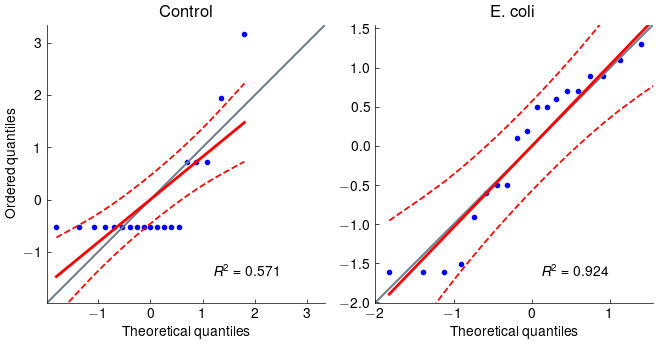

In [12]:
boxes_ = set(les.Box)

fig, axs = plt.subplots(1, len(boxes_), figsize=set_size(490, "s"))

for i, box in enumerate(boxes_):
    try:
        pg.qqplot(x=les.query("Box == @box").loc[:, "Total score"], ax=axs[i])
        axs[i].set_title(box.replace("\n", " "))

        if i > 0:
            axs[i].set_ylabel("")
    except ValueError:
        axs[i].remove()
        continue

fig.tight_layout()
clear_axes()
plt.show()

#### Levene's test

In [14]:
pg.homoscedasticity(data=les, dv="Total score", group="Box")

,W,pval,equal_var
levene,30.324807,0.000003,False


#### ANOVA (Kruskal-Wallis)

In [15]:
aov = pg.kruskal(data=les, dv="Total score", between="Box")

aov

,Source,ddof1,H,p-unc
Kruskal,Box,1,19.521762,0.00001


#### Pairwise non-parametric tests

In [16]:
stats = pg.pairwise_tests(
    data=les,
    dv="Total score",
    between="Box",
    effsize="cohen",
    parametric=False,
    padjust="fdr_bh",
)

stats

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,cohen
0,Box,Control,E. coli,False,False,39.5,two-sided,0.000011,-2.120693


### Plot

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Control vs. E. coli: Custom statistical test, P_val:1.064e-05


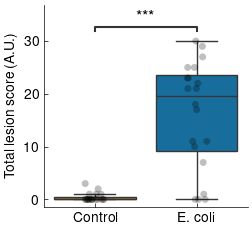

In [17]:
fig, ax = plt.subplots(figsize=set_size(190, "s"))

plot_params = dict(x="Box", y="Total score", data=les, order=sorted(PALETTE.keys()))

sns.boxplot(**plot_params, palette=PALETTE, showfliers=False)

sns.stripplot(
    **plot_params,
    color="k",
    alpha=0.25,
)

annotate_plot(ax, plot_params, stats["p-unc"])

plt.ylabel("Total lesion score (A.U.)")
plt.xlabel("")
clear_axes()
plt.savefig("img/lesion.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()

## cfu

### Data

In [18]:
cfu = (
    pd.read_excel(file, sheet_name="cfu per gram lung", header=[0, 1, 2])
    .dropna(how="all")
    .iloc[:, [0, -2]]
    .droplevel([0, 1], axis=1)
)

cfu.columns = ["Box", "cfu"]

cfu.dropna(subset="Box", inplace=True)

cfu.query("Box != 5", inplace=True)

cfu.Box = cfu.Box.astype(int).replace(boxes)

cfu.sort_values(by="Box", inplace=True)

cfu.head()

,Box,cfu
0,Control,0.000
18,Control,0.000
17,Control,7666.667
16,Control,0.000
15,Control,0.000


### Statistical analysis
#### QQ-plot

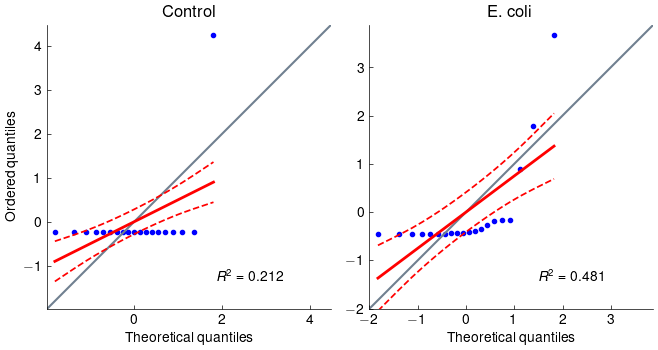

In [19]:
boxes_ = set(cfu.Box)

fig, axs = plt.subplots(1, len(boxes_), figsize=set_size(490, "s"))

for i, box in enumerate(boxes_):
    try:
        pg.qqplot(x=cfu.query("Box == @box").loc[:, "cfu"], ax=axs[i])
        axs[i].set_title(box.replace("\n", " "))

        if i > 0:
            axs[i].set_ylabel("")
    except ValueError:
        axs[i].remove()
        continue

fig.tight_layout()
clear_axes()
plt.show()

#### Levene's test

In [20]:
pg.homoscedasticity(data=cfu, dv="cfu", group="Box")

,W,pval,equal_var
levene,3.571863,0.06662,True


#### ANOVA (Kruskal-Wallis)

In [21]:
aov = pg.kruskal(data=cfu, dv="cfu", between="Box")

aov

,Source,ddof1,H,p-unc
Kruskal,Box,1,23.644101,0.000001


#### Pairwise non-parametric tests

In [22]:
stats = pg.pairwise_tests(
    data=cfu,
    dv="cfu",
    between="Box",
    effsize="cohen",
    parametric=False,
    padjust="fdr_bh",
)

stats

,Contrast,A,B,Paired,Parametric,U-val,alternative,p-unc,cohen
0,Box,Control,E. coli,False,False,31.0,two-sided,0.000001,-0.606573


### Plot

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: p <= 1.00e-03

Control vs. E. coli: Custom statistical test, P_val:1.252e-06


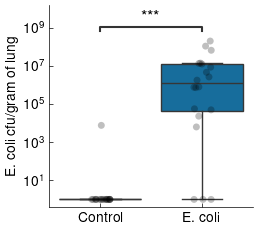

In [24]:
fig, ax = plt.subplots(figsize=set_size(190, "s"))

cfu["cfu_plus_one"] = cfu["cfu"].apply(lambda x: x + 1)

plot_params = dict(x="Box", y="cfu_plus_one", data=cfu, order=["Control", "E. coli"])

sns.boxplot(**plot_params, palette=PALETTE, showfliers=False)

sns.stripplot(
    **plot_params,
    color="k",
    alpha=0.25,
)

ax.set_yscale("log")

annotate_plot(ax, plot_params, stats["p-unc"])

ax.set_ylabel("E. coli cfu/gram of lung")
ax.set_xlabel("")
clear_axes()
plt.savefig("img/cfu.pdf", format="pdf", bbox_inches="tight", pad_inches=0)

plt.show()

# Behavioural analysis

In [28]:
vars = ["travel", "delta_area", "near_food"]

ylabels = [
    "Distance travelled\n(px/px; normalised)",
    "Change in body area\n(px$^2$/px; normalised)",
    "Time spent near\nfood source (\%)",
]

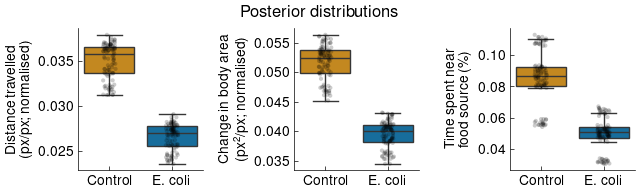

In [29]:
fig, axs = plt.subplots(1, len(vars), figsize=(6.6, 2.2))

for i, var in enumerate(vars):
    data = (
        pd.read_csv(f"data/dlc/summary_{var}.csv")
        .dropna()
        .reset_index(drop=True)
    )

    preds = (
        pd.read_csv(f"data/brms/preds_brms_{var}.csv", index_col=0)
        .dropna()
        .reset_index(drop=True)
    )

    preds["camera"] = data["camera"].map({2: "Control", 1: "E. coli"})

    plot_params = dict(
        x="camera",
        y="Estimate",
        data=preds,
        order=["Control", "E. coli"],
        ax=axs[i]
    )

    sns.boxplot(**plot_params, palette=PALETTE, showfliers=False)

    sns.stripplot(
        **plot_params,
        color="k",
        size=3,
        alpha=0.2,
    )

    axs[i].set_ylabel(ylabels[i])
    axs[i].set_xlabel("")

    clear_axes(axs[i])

fig.suptitle("Posterior distributions", y=0.9)
fig.tight_layout()
plt.savefig("img/brms_res_part1.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

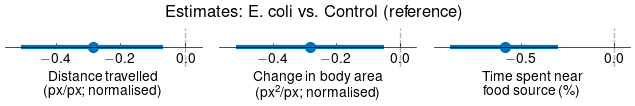

In [31]:
fig, axs = plt.subplots(1, len(vars), figsize=(6.6, 1.1))

colors = [PALETTE["E. coli"]]

for i, var in enumerate(vars):
    res = pd.read_csv(
        f"data/brms/results_brms_{var}.csv",
        index_col=0
    ).reset_index(
        names="Group"
    )

    res.Group = res.Group.apply(
        lambda x: x.replace("camera_new", "").replace("E.coli", "E. coli")
    )

    res2 = res.query("Group != 'Intercept'")

    res2.plot(
        y="Group",
        x="Estimate",
        xerr=[
            [
                res2["Estimate"].sub(res2["l-95% CI"]),
                res2["u-95% CI"].sub(res2["Estimate"]),
            ]
        ],
        kind="scatter",
        ax=axs[i],
        s=50,
        color=colors,
    )

    for j, line in enumerate(axs[i].collections[1::2]):
        line.set_color(colors)
        line.set_linewidth(3)
        line.capsize = 10

    axs[i].axvline(0, color="k", linestyle="dashed", alpha=0.3)
    axs[i].set_xlabel(f"{ylabels[i]}")
    axs[i].set_ylabel("")
    axs[i].margins(0.1)

    axs[i].spines["bottom"].set_position("center")
    axs[i].set_yticks([], [])

clear_axes(left=True)
fig.suptitle(
    "Estimates: E. coli vs. Control (reference)", y=0.8, fontsize=12
)
fig.tight_layout()
plt.savefig("img/brms_res_part2.pdf", format="pdf", bbox_inches="tight", pad_inches=0)
plt.show()

3rd part of the plot was realised in R (cf. analysis.R)